<a href="https://colab.research.google.com/github/shembree89/projects/blob/main/drop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression: Predict Bullet Drop

This will use table data from popular open-source ballistic algorithms to train a regression model to predict bullet drop in mils given: range, bullet weight, bullet length, caliber, BC, sight height, barrel twist, and muzzle velocity

In [40]:
# Use seaborn for pairplot.
!pip install -q seaborn

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [42]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.17.1


### Data
Using pandas, import data.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
url = '/content/drive/MyDrive/Ballistic Data/ballistics.data'
column_names = ['drop', 'range', 'mv', 'wt', 'len', 'bc', 'diam', 'sh','tw']

raw_dataset = pd.read_csv(url, names=column_names, sep=',', skipinitialspace=False)

In [44]:
dataset = raw_dataset.copy()
dataset.tail()

,drop,range,mv,wt,len,bc,diam,sh,tw
904,0.4,40,3000,190,1.353,0.276,0.308,2.5,10
905,0.9,30,3000,190,1.353,0.276,0.308,2.5,10
906,1.9,20,3000,190,1.353,0.276,0.308,2.5,10
907,4.9,10,3000,190,1.353,0.276,0.308,2.5,10
908,0.0,0,3000,190,1.353,0.276,0.308,2.5,10


### Split the data into training and test sets

Will use 80% of the data for training and 20% to test.

In [45]:
train_dataset = dataset.sample(frac=0.8, random_state=1)
test_dataset = dataset.drop(train_dataset.index)

In [46]:
train_dataset.tail()

,drop,range,mv,wt,len,bc,diam,sh,tw
696,-0.1,100,2850,220,1.515,0.31,0.308,2.500,10
717,8.2,900,2750,220,1.515,0.31,0.308,2.500,10
646,3.8,600,2850,220,1.515,0.31,0.308,2.500,10
628,5.9,780,2850,220,1.515,0.31,0.308,2.500,10
212,11.2,900,2800,150,1.123,0.20,0.308,2.752,10


### Inspect the data

See if there is a correlation (we know there is)

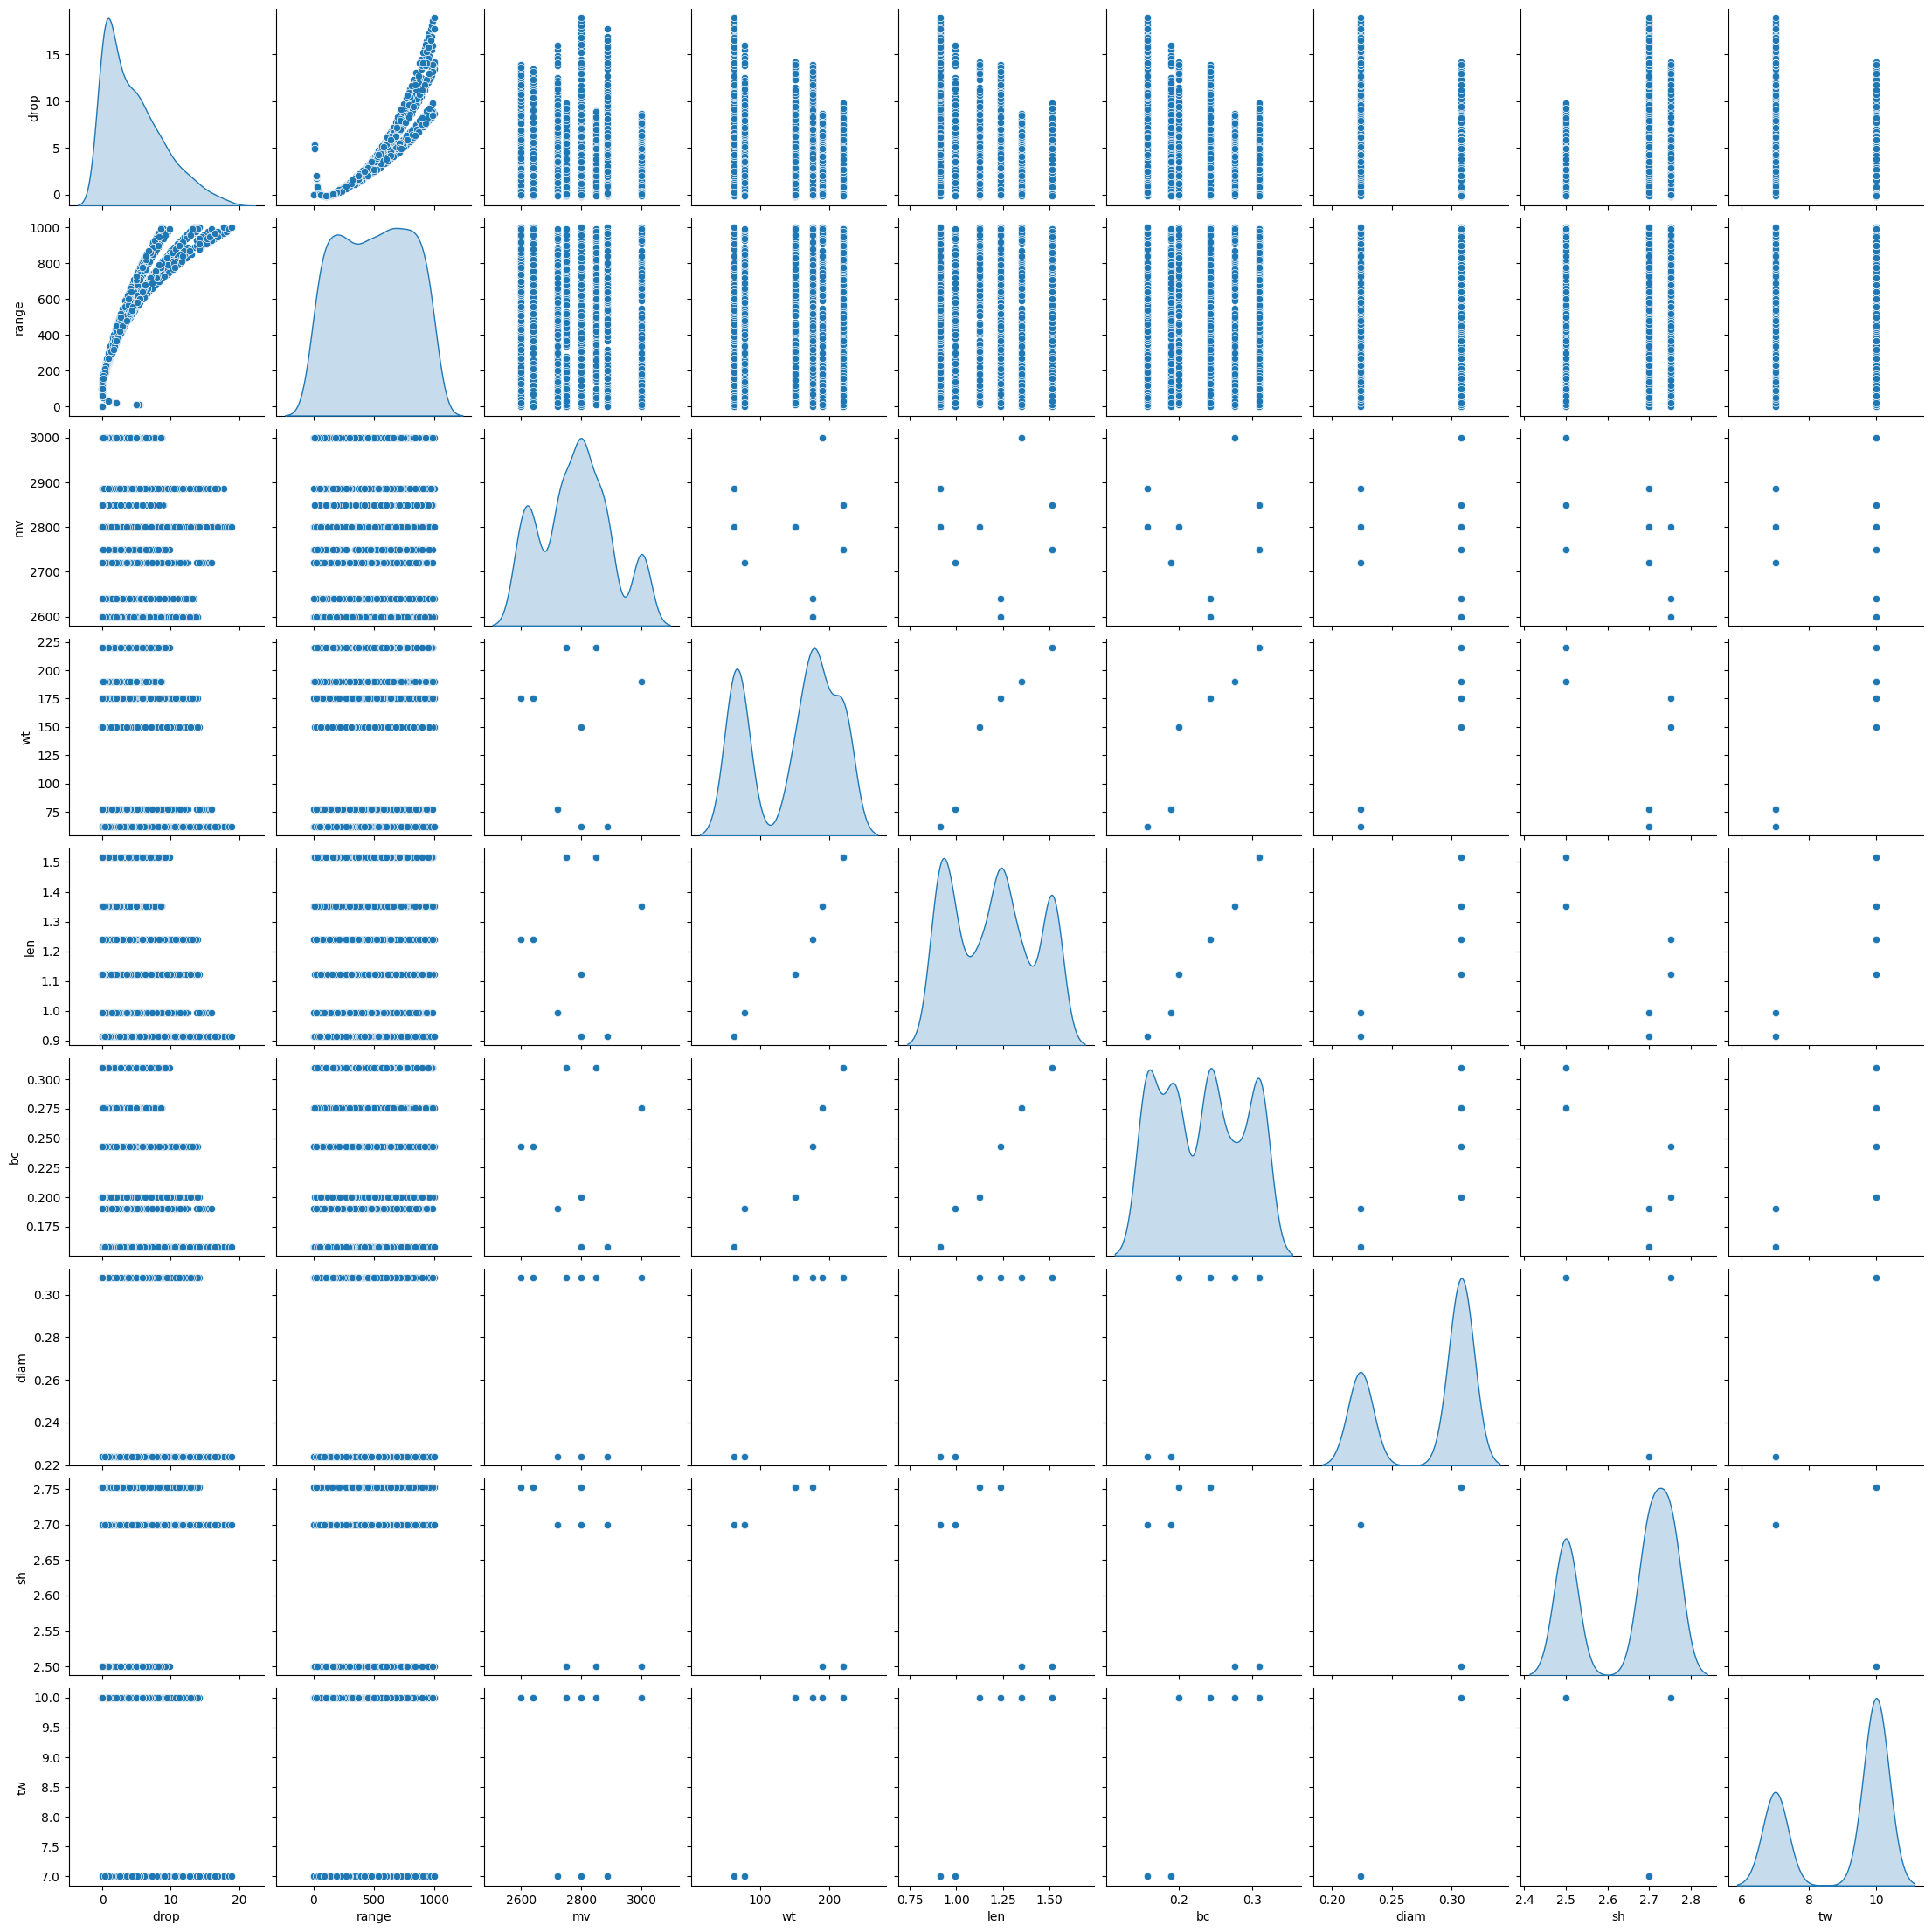

In [47]:
sns.pairplot(train_dataset[['drop', 'range', 'mv', 'wt', 'len', 'bc', 'diam', 'sh','tw']], diag_kind='kde')

Overall Statistics

In [48]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
drop,727.0,4.603989,4.288684,-0.200,0.900,3.600,7.200,18.900
range,727.0,502.778542,294.420539,0.000,240.000,510.000,760.000,1000.000
mv,727.0,2782.174691,116.746499,2600.000,2720.000,2800.000,2850.000,3000.000
wt,727.0,147.777166,60.849201,62.000,77.000,175.000,190.000,220.000
len,727.0,1.199768,0.219968,0.913,0.994,1.240,1.353,1.515
bc,727.0,0.231780,0.055700,0.158,0.190,0.243,0.276,0.310
diam,727.0,0.280039,0.039612,0.224,0.224,0.308,0.308,0.308
sh,727.0,2.651846,0.108454,2.500,2.500,2.700,2.752,2.752
tw,727.0,9.001376,1.414700,7.000,7.000,10.000,10.000,10.000


### Split features from labels

Label is the target value, the value the model will be trained to predict.

In [49]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('drop')
test_labels = test_features.pop('drop')

## Normalization

The range of values of the different columns are very different. For "Range" we have anywhere between 0 - 1k meters, for "MV" we have values in the thousands, but BC is below 1.0. For the weights to work properly we need all values to be in similar ranges while still representing their relative value. However, this means that during actual use of the model later, the input values will also have to be normalized the same way.

In [50]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
drop,4.603989,4.288684
range,502.778542,294.420539
mv,2782.174691,116.746499
wt,147.777166,60.849201
len,1.199768,0.219968
bc,0.231780,0.055700
diam,0.280039,0.039612
sh,2.651846,0.108454
tw,9.001376,1.414700


In [51]:
# create the layer
normalizer = tf.keras.layers.Normalization(axis=-1)

In [52]:
# fit preprocessing layer state to the data
normalizer.adapt(np.array(train_features))

In [53]:
# calculate the mean/variance and store in layer
print(normalizer.mean.numpy())

[[ 502.779 2782.175  147.777    1.2      0.232    0.28     2.652    9.001]]


When the layer is called, it returns the input data, with each feature independently normalized:

In [54]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 100.   2600.    175.      1.24    0.24    0.31    2.75   10.  ]]

Normalized: [[-1.37 -1.56  0.45  0.18  0.2   0.71  0.92  0.71]]


## Regression

In [55]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [56]:
drop_model = build_and_compile_model(normalizer)
drop_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization)      │ (727, 8)                    │              17 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17 (72.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 17 (72.00 B)

In [57]:
%%time
history = drop_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 10.2 s, sys: 429 ms, total: 10.6 s
Wall time: 13.9 s


In [58]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.148772,0.169089,95
96,0.142327,0.174765,96
97,0.141482,0.165015,97
98,0.137842,0.152084,98
99,0.130673,0.177130,99


In [59]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [drop]')
  plt.legend()
  plt.grid(True)

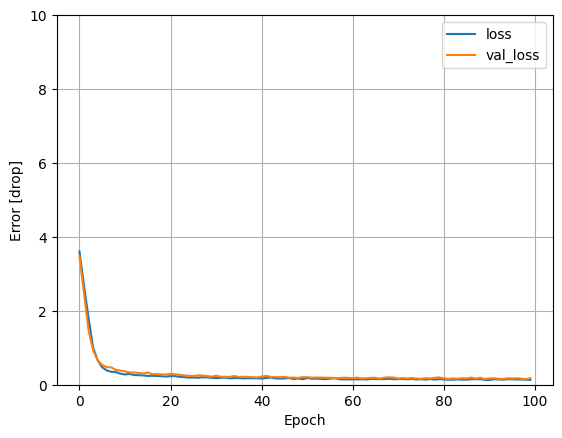

In [60]:
plot_loss(history)

Collect the results on the test set:

In [61]:
test_results = {}
test_results['drop_model'] = drop_model.evaluate(test_features, test_labels, verbose=0)

## Performance

In [62]:
pd.DataFrame(test_results, index=['Mean absolute error [drop]']).T

,Mean absolute error [drop]
drop_model,0.100348


### Make predictions

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


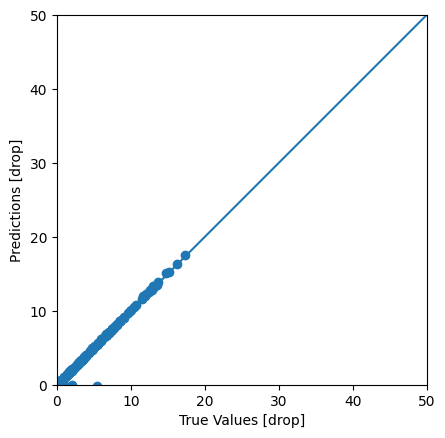

In [63]:
test_predictions = drop_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [drop]')
plt.ylabel('Predictions [drop]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


Error distribution:

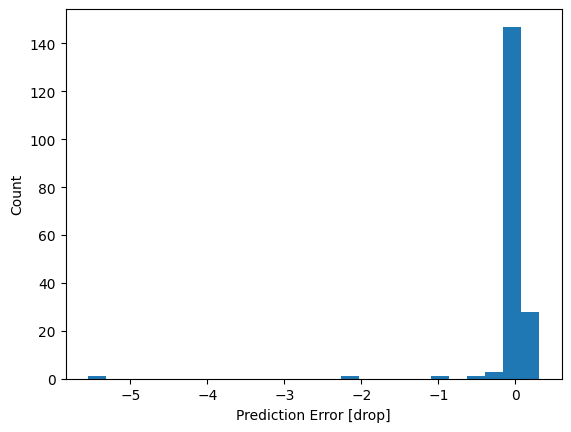

In [64]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [drop]')
_ = plt.ylabel('Count')

Save model

In [65]:
drop_model.save('drop_model.keras')

Test reloading model

In [66]:
reloaded = tf.keras.models.load_model('drop_model.keras')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [67]:
pd.DataFrame(test_results, index=['Mean absolute error [drop]']).T

,Mean absolute error [drop]
drop_model,0.100348
reloaded,0.100348
